For one of our models, we have decided to use k-Nearest Neighbours. While kNN has some limitations, particularly with computational efficiency and sensitivity to irrelevant features, kNN was selected for its interpretability and ease of implementation. Its non-parametric nature means that it makes no assumptions about the underlying distribution of the data, a useful characteristic in situations like ours where the dataset is imbalanced. Furthermore, kNN can be adapted easily by adjusting the number of neighbors (k) and the distance metric to better handle this imbalance and improve the prediction of minority class events, such as customer churn.

In [1]:
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.neighbors import KNeighborsClassifier  # Importing KNN classifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score
import pickle

In [3]:
# Load the training and testing split from the pickle file
with open('train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

# Load the different splits
with open('train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

Optimal value of k for random split: 3
Optimal value of k for stratified split: 7
Optimal value of k for udersample split: 17
Optimal value of k for oversample split: 1


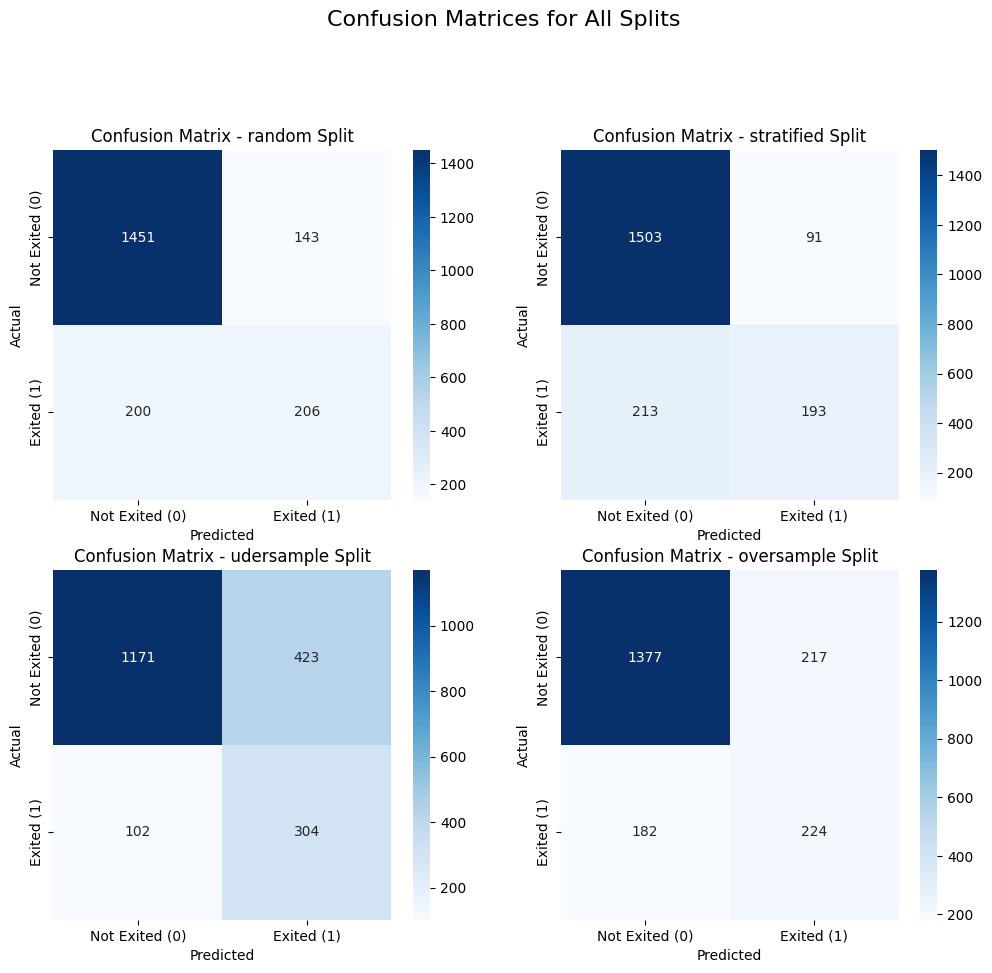

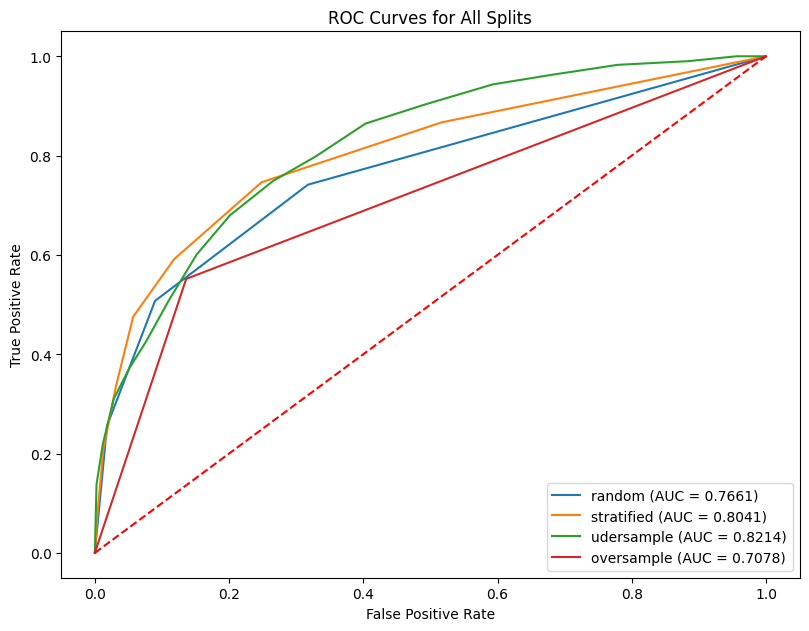

{'random': {'best_k': 3,
  'val_accuracy': 0.82125,
  'test_accuracy': 0.8285,
  'precision_class_1': 0.5902578796561605,
  'recall_class_1': 0.5073891625615764,
  'f1_score_class_1': 0.5456953642384106,
  'roc_auc': np.float64(0.7661218794617747)},
 'stratified': {'best_k': 7,
  'val_accuracy': 0.84,
  'test_accuracy': 0.848,
  'precision_class_1': 0.6795774647887324,
  'recall_class_1': 0.4753694581280788,
  'f1_score_class_1': 0.5594202898550724,
  'roc_auc': np.float64(0.8041439264235959)},
 'udersample': {'best_k': 17,
  'val_accuracy': 0.765625,
  'test_accuracy': 0.7375,
  'precision_class_1': 0.41815680880330125,
  'recall_class_1': 0.7487684729064039,
  'f1_score_class_1': 0.5366284201235657,
  'roc_auc': np.float64(0.8213968947592881)},
 'oversample': {'best_k': 1,
  'val_accuracy': 0.791875,
  'test_accuracy': 0.8005,
  'precision_class_1': 0.5079365079365079,
  'recall_class_1': 0.5517241379310345,
  'f1_score_class_1': 0.5289256198347108,
  'roc_auc': np.float64(0.70779431

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer, f1_score

# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Set up a range of k values to search
param_grid = {'n_neighbors': list(range(1, 19))}  # Test k from 1 to 20

# Initialize a new figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Initialize a new figure for ROC curves
plt.figure(figsize=(8, 6))

# Dictionary to store performance metrics for each split
performance_metrics = {}

# Loop over each split
for idx, split in enumerate(split_data.keys()):
    # Unpack the current split
    X_train_split, X_val_split, y_train_split, y_val_split = split_data[split]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Initialize kNN model and GridSearchCV
    # # Parallelize the search across all available CPU cores
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)
    
    # Fit the model using cross-validation to find the best k
    grid_search.fit(X_train_scaled, y_train_split)
    
    # Get the best k for this split
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Optimal value of k for {split} split: {best_k}")
    
    # Use the best k to train the final model
    knn_best = KNeighborsClassifier(n_neighbors=best_k)
    knn_best.fit(X_train_scaled, y_train_split)
    
    # Predict on validation set
    y_val_pred = knn_best.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Predict on test set
    y_test_pred = knn_best.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)
    
    # Get classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Extract performance metrics for class 1
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score_val = test_report['1']['f1-score']
    
    # ROC curve
    y_test_pred_prob = knn_best.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    
    # Store performance metrics for this split
    performance_metrics[split] = {
        'best_k': best_k,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'precision_class_1': precision,
        'recall_class_1': recall,
        'f1_score_class_1': f1_score_val,
        'roc_auc': roc_auc
    }

# Finalize confusion matrix plot
plt.tight_layout()
fig.suptitle('Confusion Matrices for All Splits', y=1.02, fontsize=16)

# Finalize ROC curves plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')
plt.show()

# Output the performance metrics for each split
performance_metrics
